In [1]:
import numpy as np

def ising_hamiltonian(n_spin: int, J: float, h: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Construct an Ising Hamiltonian in a spin-1/2 basis using Pauli operators:
        H = -J ∑ Z_i Z_{i+1} - h ∑ X_i
    This function returns a qubit Hamiltonian compatible with fermionic-to-qubit conversion logic.
    Since h1e and h2e are expected, we encode -h ∑ X_i as "1-body" and -J ∑ Z_i Z_{i+1} as "2-body".
    """
    h1e = np.zeros((n_spin, n_spin))
    h2e = np.zeros((n_spin, n_spin, n_spin, n_spin))
    # Transverse field term: -h X_i → modeled as one-body term
    # In Jordan-Wigner mapping, this becomes non-local, but we stay abstract here
    for i in range(n_spin):
        h1e[i, i] = -h
 
    # Ising coupling: -J Z_i Z_{i+1} → modeled as two-body term
    for i in range(n_spin - 1):
        h2e[i, i, i + 1, i + 1] = -J
 
    return h1e, h2e

In [2]:
# Set the number of spins
n_spin = 16
 
# Effective Ising parameters (must match h1e/h2e construction)
J = 1.0
h = 0.5

h1e, h2e = ising_hamiltonian(n_spin, J=J, h=h)

In [3]:
import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CPhaseGate, XGate, XXPlusYYGate, RXGate, RZGate, CXGate
import numpy as np

nelec = (1, 1)

dt = 0.2
Utar = scipy.linalg.expm(-1j * dt * h1e)

def initial_state(q_circuit, n_up):
    """Simple reference state for TFIM"""
    # Just flip the first n_up spins
    # for i in range(n_up):
        # q_circuit.x(i)
    # No complex rotations needed - TFIM is much simpler!


# The one-body time evolution
def append_one_body_evolution(q_circuit, dt, h, n_spins):
    """
    Apply e^{ih*dt*∑_i X_i} = ∏_i e^{ih*dt*X_i}
    Each term is just an RX rotation!
    """
    for i in range(n_spins):
        # e^{ih*dt*X_i} = RX(2*h*dt)
        q_circuit.append(RXGate(2 * h * dt), [i])

# The two-body time evolution
def append_two_body_evolution(q_circuit, dt, n_spins):
    """
    Apply e^{i*dt*∑_i Z_i Z_{i+1}}
    Each ZZ term can be implemented with CNOT-RZ-CNOT
    """
    for i in range(n_spins - 1):  # nearest neighbors
        # e^{i*dt*Z_i*Z_{i+1}} implementation:
        q_circuit.append(CXGate(), [i, i + 1])      # CNOT
        q_circuit.append(RZGate(2 * dt), [i + 1])   # RZ(2*dt)  
        q_circuit.append(CXGate(), [i, i + 1])      # CNOT

In [4]:
# Generate the initial state
qubits = QuantumRegister(n_spin, name="q")
init_state = QuantumCircuit(qubits)
initial_state(init_state, n_spin // 2)
init_state.draw("mpl", scale=0.4, fold=-1)

d = 8  # Number of Krylov basis states
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        append_two_body_evolution(circ, dt, n_spin)
        append_one_body_evolution(circ, dt, h, n_spin)
        append_two_body_evolution(circ, dt, n_spin)
    circ.measure_all()

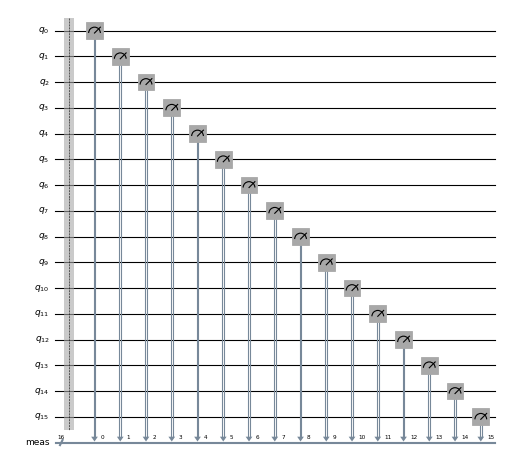

In [5]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

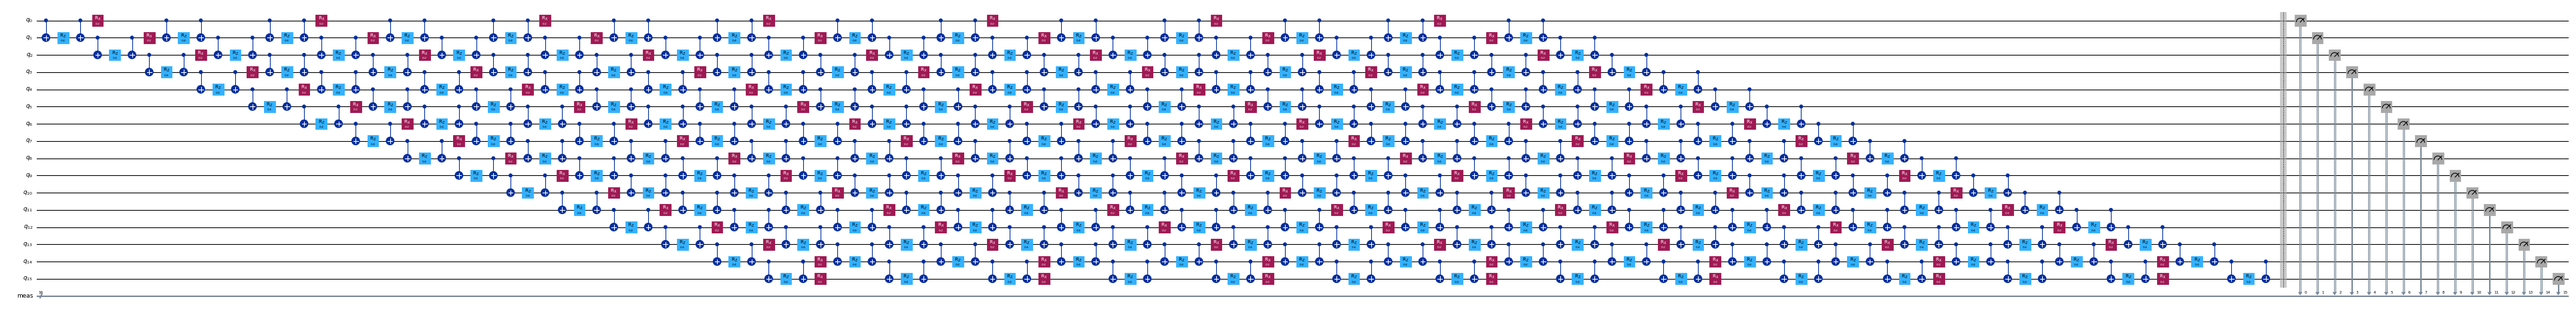

In [6]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()

token = os.getenv("QISKIT_IBM_RUNTIME_TOKEN")
instance = os.getenv("QISKIT_IBM_RUNTIME_INSTANCE")

In [8]:
from qiskit_ibm_runtime.fake_provider.backends import FakeSherbrooke
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit_ibm_runtime import QiskitRuntimeService

backend = FakeAlmadenV2()

# service = QiskitRuntimeService(channel='ibm_cloud', token=token, instance=instance)
# backend = service.least_busy(simulator=False, operational=True)
# print(f"Using backend: {backend}")

In [9]:
from qiskit.transpiler import generate_preset_pass_manager

# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = pass_manager.run(circuits)

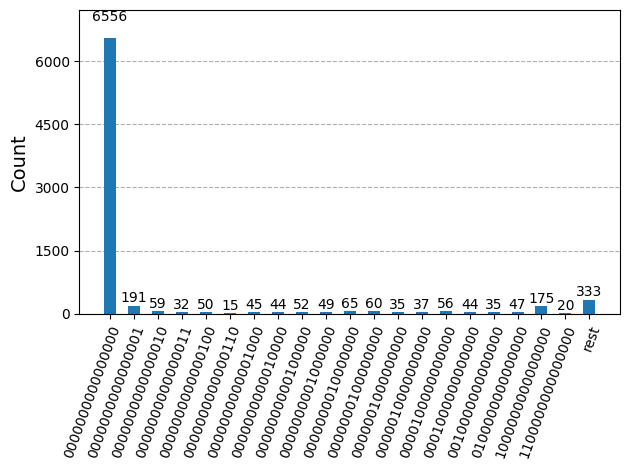

In [10]:
from qiskit.primitives import BitArray
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
noisy_sampler = Sampler(backend, options={"simulator": {"seed_simulator": 24}})
job = noisy_sampler.run(isa_circuits, shots=1000)

# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots([result.data.meas for result in job.result()])

plot_histogram(bit_array.get_counts(), number_to_keep=20)

In [11]:
from fermion import SCIResult, diagonalize_fermionic_hamiltonian

# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

rng = np.random.default_rng(24)
norb = n_spin//2  # Number of orbitals is equal to the number of spins

print("bit_array shape:", bit_array.shape)
print("norb:", norb, "nelec:", nelec)

result = diagonalize_fermionic_hamiltonian(
    h1e,
    h2e,
    bit_array,
    samples_per_batch=300,
    norb=norb,
    nelec=nelec,
    num_batches=1,
    max_iterations=5,
    symmetrize_spin=False,
    callback=callback,
    seed=rng,
)

bit_array shape: ()
norb: 8 nelec: (1, 1)
Iteration 1
	Subsample 0
		Energy: -1.0
		Subspace dimension: 64


/Users/hf/Python/QuantumHarbringers/test/qiskit_addon_sqd/configuration_recovery.py:236: RuntimeWarning: invalid value encountered in divide
  probs_left = probs_left / np.sum(probs_left)


ValueError: Probabilities contain NaN

Exact energy: -13.42249
SQD energy: -12.54307
Absolute error: 0.87942


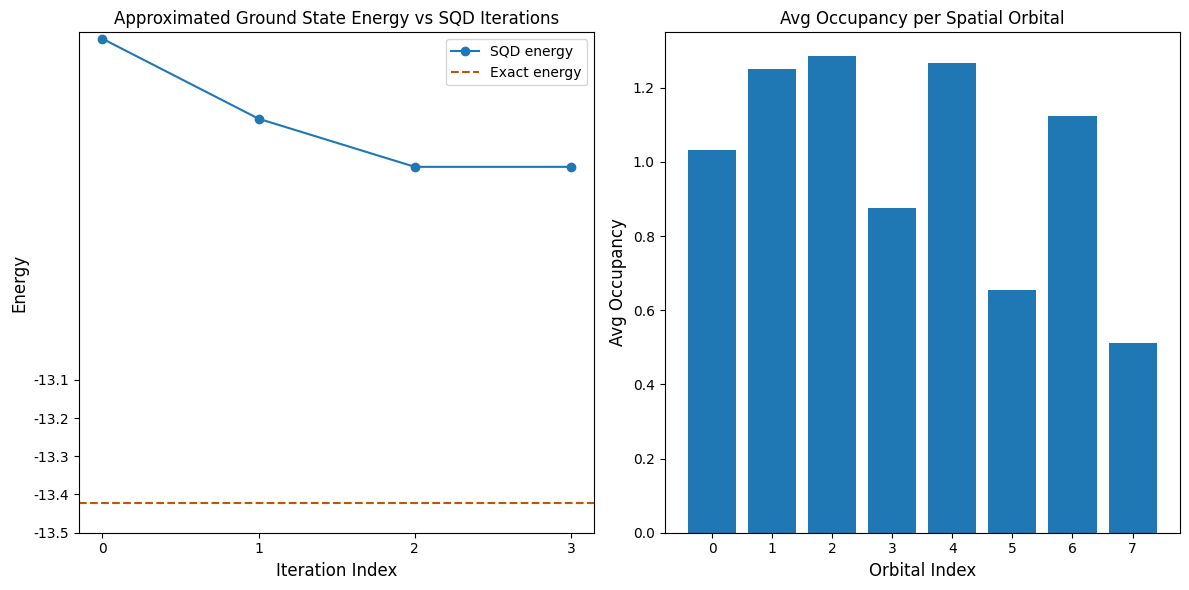

In [ ]:
import matplotlib.pyplot as plt

exact_energy = -13.422491814605827
min_es = [min(result, key=lambda res: res.energy).energy for result in result_history]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(len(result_history))
yt1 = list(np.arange(-13.5, -13.1, 0.1))
ytl = [f"{i:.1f}" for i in yt1]

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="SQD energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(ytl)
axs[0].axhline(y=exact_energy, color="#BF5700", linestyle="--", label="Exact energy")
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - exact_energy):.5f}")
plt.tight_layout()
plt.show()